# Goal

I want to write code to do the following:

1. Select column(s) from scored_map
2. if columns, do maths to combine into column
3. Interpolate
4. Make 256x256 tiles which are colormapped and alpha'd
5. Write tiles to sochor.co
6. Use sochor.co html google magic t show overlaid map

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport mapster
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import time
import numpy as np
from scipy.interpolate import griddata
import Image as pil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
jp = pd.read_pickle('./pickles/jamaica_plain.pkl')
jp.head()

,px,py,address,lat,lng,pizza,pizza-source,burger,burger-source,mexican,mexican-source,chinese,chinese-source,thai,thai-source,tx,ty
0,1268450,1552250,"1153 Centre Street, Boston, MA 02130, USA",42.301817,-71.128063,75.673469,yelp-min,55.250000,yelp-min,75.183673,yelp-min,116.437500,yelp-min,152.444444,yelp-min,4954,6063
1,1268450,1552225,"70 Westchester Road, Jamaica Plain, MA 02130, USA",42.303404,-71.128063,72.000000,yelp-min,67.187500,yelp-min,90.775510,yelp-min,124.897959,yelp-min,142.666667,yelp-min,4954,6063
2,1268450,1552200,"52 Louders Lane, Jamaica Plain, MA 02130, USA",42.304991,-71.128063,57.937500,yelp-min,66.666667,yelp-min,91.591837,yelp-min,75.265306,yelp-min,117.666667,yelp-min,4954,6063
3,1268450,1552175,"3 David Road, Jamaica Plain, MA 02130, USA",42.306578,-71.128063,71.250000,yelp-min,67.456790,yelp-min,108.979592,yelp-min,92.571429,yelp-min,141.333333,yelp-min,4954,6063
4,1268450,1552150,"4 Driftwood Road, Jamaica Plain, MA 02130, USA",42.308165,-71.128063,76.750000,yelp-min,64.148148,yelp-min,109.306122,yelp-min,99.836735,yelp-min,141.444444,yelp-min,4954,6063


## pizza

We will start simple by trying to print out tiles for the pizza column

# current interp data

```

def interpolate_yelp_score(scores,plot=False,method='nearest'):
    pixels = scores.keys()
    searches = scores.index
    px = []
    py = []
    for pixel in pixels:
        pix = pixel.split(':')
        px.append(float(pix[0]))
        py.append(float(pix[1]))
    xsteps_fine = 1
    ysteps_fine = 1
    x_fine,y_fine = np.mgrid[np.min(px):np.max(px):xsteps_fine,np.min(py):np.max(py):ysteps_fine]
    interp = {}
    for search in searches: 
        points = [[]]
        mask_points = [[]]
        values = []
        mask_values = []
        mask_flag=True
        for i,x in enumerate(px):
            if mask_flag:
                mask_points = [[x,py[i]]]
            else:
                mask_points.append([x,py[i]])
            if not np.isnan(scores[pixels[i]][search]):
                if mask_flag:
                    mask_values=[128]
                    mask_flag = False
                else:
                    mask_values.append(128)
                    
                if len(points[0]) == 0:
                    points = [[x,py[i]]]
                    values = [scores[pixels[i]][search]]
                else:
                    points.append([x,py[i]])
                    values.append(scores[pixels[i]][search])
            else:
                if mask_flag:
                    mask_values=[0]
                    mask_flag = False
                else:
                    mask_values.append(0)
                
        grid = griddata(np.matrix(points), np.array(values), (x_fine, y_fine), method)
        grid_mask = griddata(np.matrix(mask_points), np.array(mask_values), (x_fine, y_fine), method)
        interp[search] = grid.T
        if plot:
            plt.figure()
            plt.imshow(grid)
            plt.title(search)
            plt.figure()
            plt.imshow(grid_mask)
            plt.title(search+' mask')
            
    return x_fine,y_fine,interp
```

In [7]:
watertown = pd.read_pickle('./pickles/watertown.pkl')
watertown.keys()

Index([u'px', u'py', u'address', u'lat', u'lng', u'pizza', u'pizza-source', u'burger', u'burger-source', u'mexican', u'mexican-source', u'chinese', u'chinese-source', u'thai', u'thai-source', u'coffee', u'coffee-source', u'diner', u'diner-source', u'indian', u'indian-source', u'tx', u'ty'], dtype='object')

In [8]:
def draw_mapster(map_area,searches,mode='nearest',alpha=128):
    if isinstance(searches,str):
        searches = [searches]
    map_area = map_area.sort(['px','py'])
    px = map_area['px']
    py = map_area['py']
    tx = list(set(map_area['tx']))
    ty = list(set(map_area['ty']))
    #print tx,ty
    x_fine,y_fine = np.mgrid[np.min(px):np.max(px):1,np.min(py):np.max(py):1]

    points = np.matrix([[x,y] for x,y in zip(px,py)])
    first = True
    
    for search in searches:
        if first:
            values = np.array(map_area[search])
            first = False
            im_name = search
        else:
            values += np.array(map_area[search])
            im_name += '_'+search
    
    values = values/len(searches)
    grid = griddata(points,values,(x_fine,y_fine),mode)
    #print grid[0][0],grid[-1][-1]
    #plt.figure()
    #plt.imshow(grid)
    #plt.title('grid')
    gmax = max([max(g) for g in grid])
    gnorm = grid.T/gmax

    im = pil.fromarray(np.uint8(plt.cm.jet(gnorm)*255))
    
    mintile = get_tile_pixels(min(tx),min(ty))
    maxtile = get_tile_pixels(max(tx),max(ty))

    x_off,y_off = int(min(px) - mintile[0]),int(min(py)-mintile[1])
    bigmap = np.zeros((maxtile[3]-mintile[1],maxtile[2]-mintile[0]))
    #print len(gnorm),len(gnorm[0])
    bigmap[y_off:y_off+len(gnorm),x_off:x_off+len(gnorm[0])] = gnorm
    #plt.figure()
    #plt.imshow(bigmap)
    #plt.title('bigmap')
    im = pil.fromarray(np.uint8(plt.cm.jet(bigmap)*255))
    alpha_layer = np.zeros((maxtile[3]-mintile[1],maxtile[2]-mintile[0]))
    alpha_layer[bigmap > 0] = alpha
    alpha_im = pil.fromarray(alpha_layer)
    alpha_im = alpha_im.convert('L')
    r,g,b,a = im.split()

    final_im = pil.merge('RGBA',(r,g,b,alpha_im))
    make_tiles(tx,ty,final_im,im_name)

In [9]:


def get_tile_pixels(tx,ty):
    return (tx*256,ty*256,tx*256+256,ty*256+256)

def make_tiles(tilex,tiley,im,name):
    xoff = min(tilex)*256
    yoff = min(tiley)*256
    #im = im.transpose(pil.ROTATE_90)
    for tx in tilex:
        for ty in tiley:
            pixels = get_tile_pixels(tx,ty)
            box = (pixels[0]-xoff,pixels[1]-yoff,pixels[2]-xoff,pixels[3]-yoff)
            region = im.crop(box)
            fname = './tiles/'+name+'_'+str(tx)+'_'+str(ty)+'.png'
            region.save(fname)

In [262]:
pxmin = min(watertown['px'])
pxmax = max(watertown['px'])
pymin = min(watertown['py'])
pymax = max(watertown['py'])
print pxmin, pxmax, pymin, pymax

1267800.0 1268450.0 1550875.0 1551425.0


In [263]:
print pxmin-4952*256, pymin-6058*256

88.0 27.0


In [16]:
draw_mapster(jp,['burger'])

In [24]:
map_yelp_watertown = pd.read_pickle('./pickles/map_yelp_watertown.pkl')
map_yelp_jp = pd.read_pickle('./pickles/map_yelp_jamaica_plain.pkl')

In [27]:
searches = list(set(map_yelp_watertown['search']))
for search in searches:
    mapster.draw_mapster(watertown,search)

searches = list(set(map_yelp_jp['search']))
for search in searches:
    mapster.draw_mapster(jp,search)    

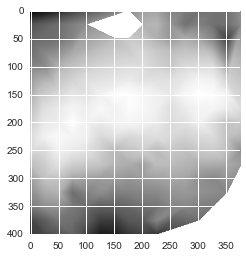

In [26]:
mapster.draw_mapster(jp,['burger'],mode='linear',alpha=64)

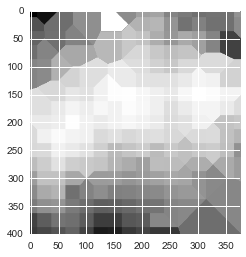

In [22]:
map_area = jp
searches = ['burger']
mode = 'nearest'
map_area = map_area.sort(['px','py'])
px = map_area['px']
py = map_area['py']
tx = list(set(map_area['tx']))
ty = list(set(map_area['ty']))

x_fine,y_fine = np.mgrid[np.min(px):np.max(px):1,np.min(py):np.max(py):1]

points = np.matrix([[x,y] for x,y in zip(px,py)])
first = True

for search in searches:
    if first:
        values = np.array(map_area[search])
        first = False
        im_name = search
    else:
        values += np.array(map_area[search])
        im_name += '_'+search

values = values/len(searches)
grid = griddata(points,values,(x_fine,y_fine),mode)
plt.imshow(grid)

In [21]:
grid[0]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n